In [1]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification
from contrastive import Contrastive_loss
from utils import plot_tsne,Net_embed
import torch
import numpy as np


In [2]:


X,y = make_classification(n_samples=3000,n_features=16,n_classes=4,n_clusters_per_class=1)



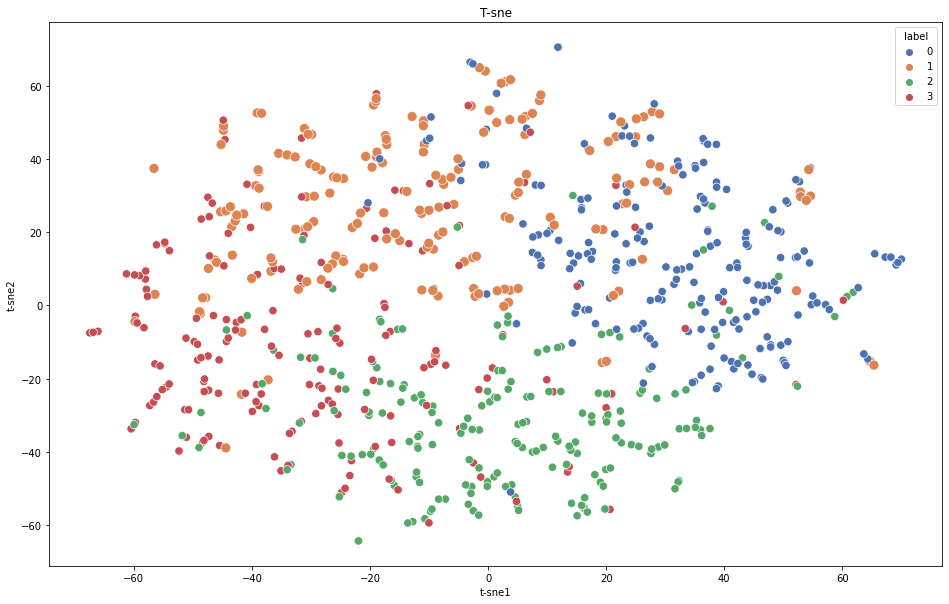

In [3]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=2)
X_train,y_train = torch.from_numpy(X_train).float(),torch.from_numpy(y_train).float()
plot_tsne(X_test,y_test)




In [4]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

pred = neigh.predict(X_test)
Acc = (pred == y_test).sum()/len(pred)
print(Acc)

0.76


In [5]:
net = Net_embed(input_dim=X_train.shape[1],hidden_dim=128,out_dim=64,drop_prob=0.2)

N_epoch = 20
batches_per_epoch = 750
N_samp_batch = 20
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

net.train()
pos_train = np.where(y_train==1)[0]
neg_train = np.where(y_train==0)[0]

criterion = Contrastive_loss(margin=0.1)
for n in range(N_epoch):
    batch_loss = 0
    for i in range(batches_per_epoch) :
        optimizer.zero_grad()
        pos_samp = np.random.choice( pos_train , N_samp_batch , replace=False)
        neg_samp = np.random.choice( neg_train , N_samp_batch , replace=False)
        data_b = X_train[np.concatenate((pos_samp,neg_samp)),:]
        labels_b = y_train[np.concatenate((pos_samp,neg_samp))]
        pred = net(data_b)
        loss = criterion(pred,labels_b)
        loss.backward()
        optimizer.step()
        batch_loss += float(loss)
    
    print(f" epoch: {n}  Loss:  {batch_loss}")

 epoch: 0  Loss:  24.943928608379792
 epoch: 1  Loss:  15.101932804958778
 epoch: 2  Loss:  12.582613957689318
 epoch: 3  Loss:  11.787680799847294
 epoch: 4  Loss:  11.43343246596487
 epoch: 5  Loss:  10.602730698230516
 epoch: 6  Loss:  9.90191923392922
 epoch: 7  Loss:  10.213791376061636
 epoch: 8  Loss:  9.56239618847576
 epoch: 9  Loss:  9.272342285014929
 epoch: 10  Loss:  9.306673052474252
 epoch: 11  Loss:  8.422104179065627
 epoch: 12  Loss:  8.399795701302082
 epoch: 13  Loss:  7.721919279928898
 epoch: 14  Loss:  7.759066458558209
 epoch: 15  Loss:  8.131855697010906
 epoch: 16  Loss:  7.99214059677297
 epoch: 17  Loss:  7.622216052657677
 epoch: 18  Loss:  7.18110267284419
 epoch: 19  Loss:  6.811901555028271


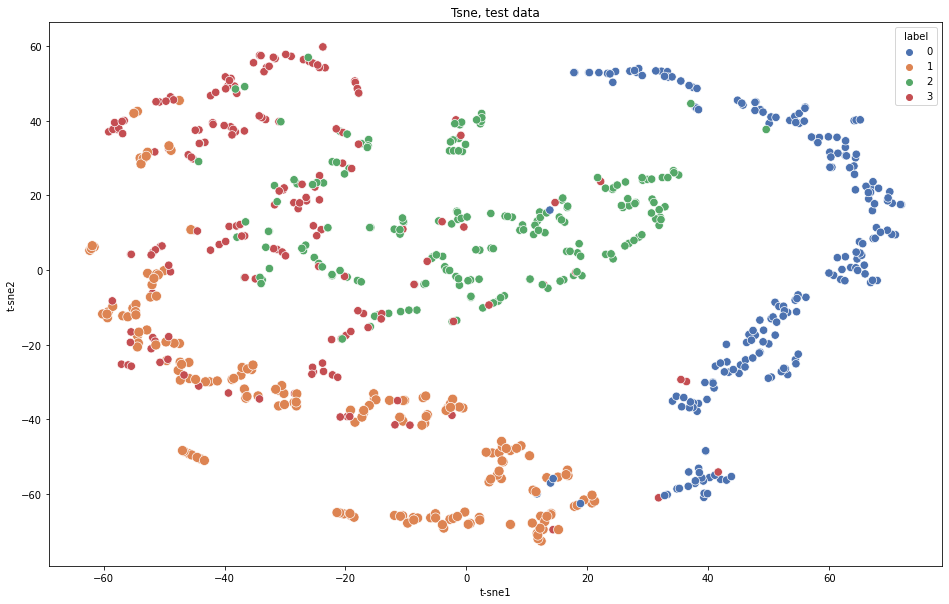

In [6]:
net.eval()
pred_test = net(torch.from_numpy(X_test).float())

plot_tsne(pred_test.detach().numpy(),y_test,title = 'Tsne, test data')

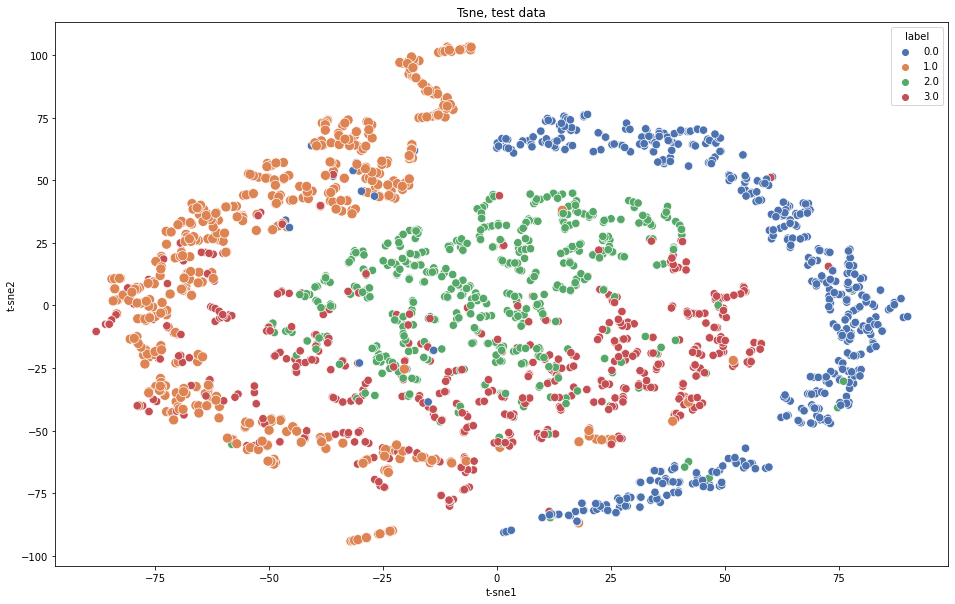

In [7]:
pred_train = net(X_train)

plot_tsne(pred_train.detach().numpy(),y_train,title = 'Tsne, test data')

In [8]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(pred_train.detach().numpy(), y_train.numpy())

pred = neigh.predict(pred_test.detach().numpy())
Acc = (pred == y_test).sum()/len(pred)
print(Acc)

0.852
